In [ ]:
!pip install numpy==1.23.5
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
import os

# Download dataset

In [ ]:
import kagglehub

path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/smart-meters-in-london


# Read Datasets

## Read hh_block_0

In [ ]:
hh_block_0 = pd.read_csv('/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_0.csv', parse_dates=['day'])

## Read hourly weather dataset

In [ ]:
weather = pd.read_csv('/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=['time'], index_col='time')

## block_0 head

In [ ]:
hh_block_0.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


## weather dataset head

In [ ]:
weather.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


# Data Preprocessing

## Filter rows for a specific ID

In [ ]:
hh_block_0_filtered = hh_block_0[hh_block_0['LCLid'] == 'MAC000002'].copy()

In [ ]:
hh_block_0_filtered.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


## Drop the 'LCLid' column

In [ ]:
hh_block_0_filtered.drop(columns='LCLid', inplace=True)

In [ ]:
hh_block_0_filtered.head()

,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,hh_8,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,0.167,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,0.120,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,0.124,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,0.091,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,0.080,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


##Melt the hh_ columns into one column (long format)

In [ ]:
hh_block_0_filtered = hh_block_0_filtered.melt(id_vars=['day'],
                       value_vars=[col for col in hh_block_0_filtered.columns if col.startswith('hh_')],
                       var_name='half_hour',
                       value_name='consumption')

In [ ]:
hh_block_0_filtered.head()

,day,half_hour,consumption
0,2012-10-13,hh_0,0.263
1,2012-10-14,hh_0,0.262
2,2012-10-15,hh_0,0.192
3,2012-10-16,hh_0,0.237
4,2012-10-17,hh_0,0.157


## Sort by date and half-hour slot

In [ ]:
hh_block_0_filtered['day'] = pd.to_datetime(hh_block_0_filtered['day'])
hh_block_0_filtered = hh_block_0_filtered.sort_values(['day', 'half_hour'])

In [ ]:
hh_block_0_filtered.head()

,day,half_hour,consumption
0,2012-10-13,hh_0,0.263
498,2012-10-13,hh_1,0.269
4980,2012-10-13,hh_10,0.168
5478,2012-10-13,hh_11,0.107
5976,2012-10-13,hh_12,0.166


## Extract the half-hour index

In [ ]:
hh_block_0_filtered['hh_index'] = hh_block_0_filtered['half_hour'].str.extract('hh_(\d+)').astype(int)

## Create datetime index: date + hh_index * 30 minutes

In [ ]:
hh_block_0_filtered['datetime'] = hh_block_0_filtered['day'] + pd.to_timedelta(hh_block_0_filtered['hh_index'] * 30, unit='min')

##Set the datetime index and drop unnecessary columns

In [ ]:
hh_block_0_filtered = hh_block_0_filtered.set_index('datetime')[['consumption']]

In [ ]:
hh_block_0_filtered.head()

,consumption
datetime,
2012-10-13 00:00:00,0.263
2012-10-13 00:30:00,0.269
2012-10-13 05:00:00,0.168
2012-10-13 05:30:00,0.107
2012-10-13 06:00:00,0.166


In [ ]:
hh_block_0_hourly = hh_block_0_filtered.resample("H").mean()

In [ ]:
hh_block_0_hourly.head()

,consumption
datetime,
2012-10-13 00:00:00,0.2660
2012-10-13 01:00:00,0.2655
2012-10-13 02:00:00,0.1735
2012-10-13 03:00:00,0.1400
2012-10-13 04:00:00,0.1380


## Join with weather dataset

In [ ]:
hh_block_0_hourly_weather = hh_block_0_hourly.join(weather['temperature']).dropna()

In [ ]:
hh_block_0_hourly_weather.head()

,consumption,temperature
datetime,,
2012-10-13 00:00:00,0.2660,8.78
2012-10-13 01:00:00,0.2655,8.27
2012-10-13 02:00:00,0.1735,7.87
2012-10-13 03:00:00,0.1400,7.89
2012-10-13 04:00:00,0.1380,7.74


In [ ]:
hh_block_0_hourly_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11950 entries, 2012-10-13 00:00:00 to 2014-02-27 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  11950 non-null  float64
 1   temperature  11950 non-null  float64
dtypes: float64(2)
memory usage: 280.1 KB


## Changing Frequencies

In [ ]:
hourly_data = hh_block_0_hourly_weather.resample('H').mean().dropna()
daily_data = hh_block_0_hourly_weather.resample('D').mean().dropna()
weekly_data = hh_block_0_hourly_weather.resample('W').mean().dropna()
monthly_data = hh_block_0_hourly_weather.resample('M').mean().dropna()
annualy_data = hh_block_0_hourly_weather.resample('A').mean().dropna()

# Show some plots

##Original data

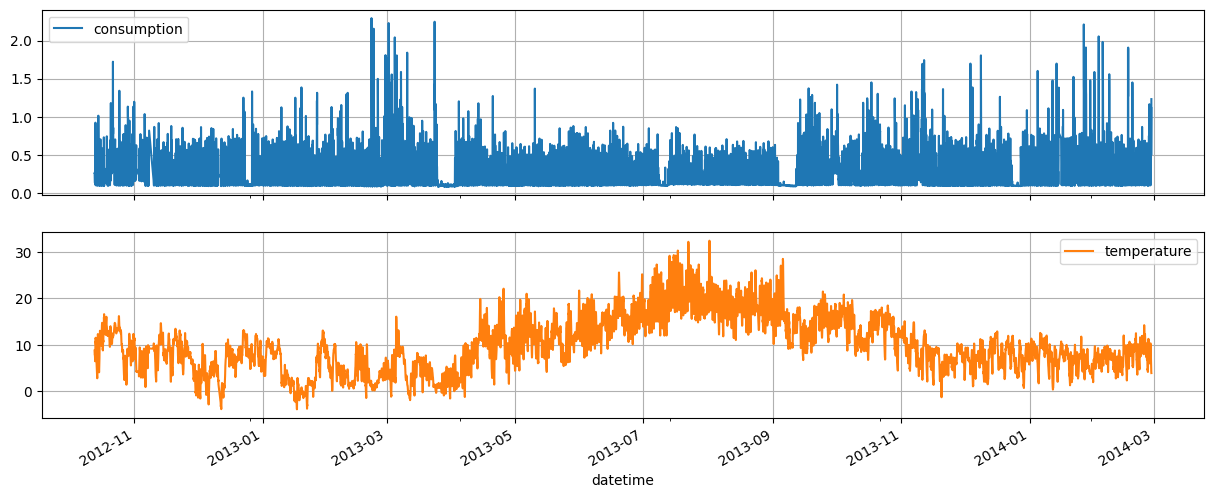

In [ ]:
hh_block_0_hourly_weather.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

## Plot differtent Frequencies

- as we can observe the consumption increase when the temprature decreases

### Hourly

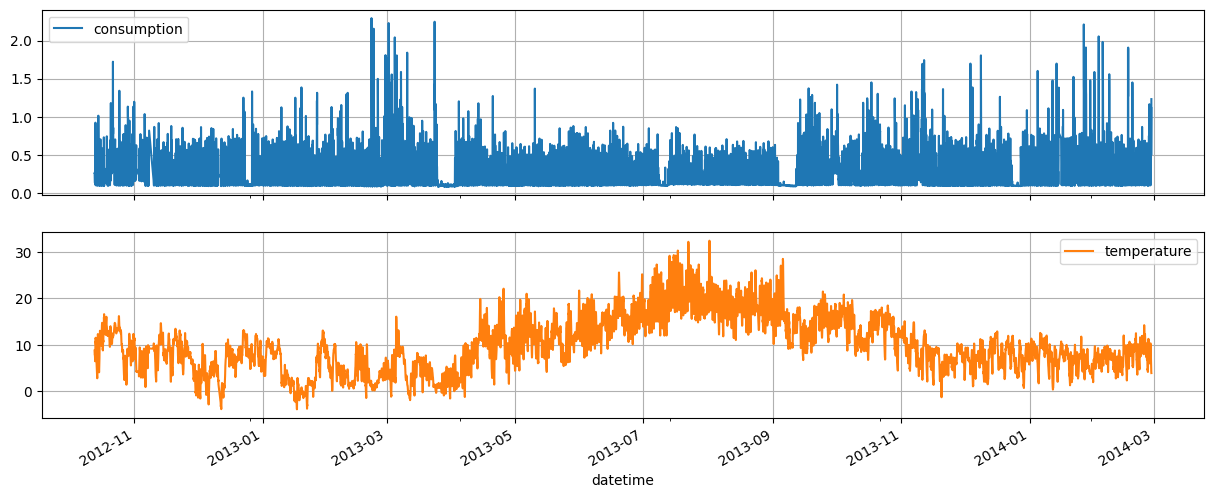

In [ ]:
hourly_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

### Daily

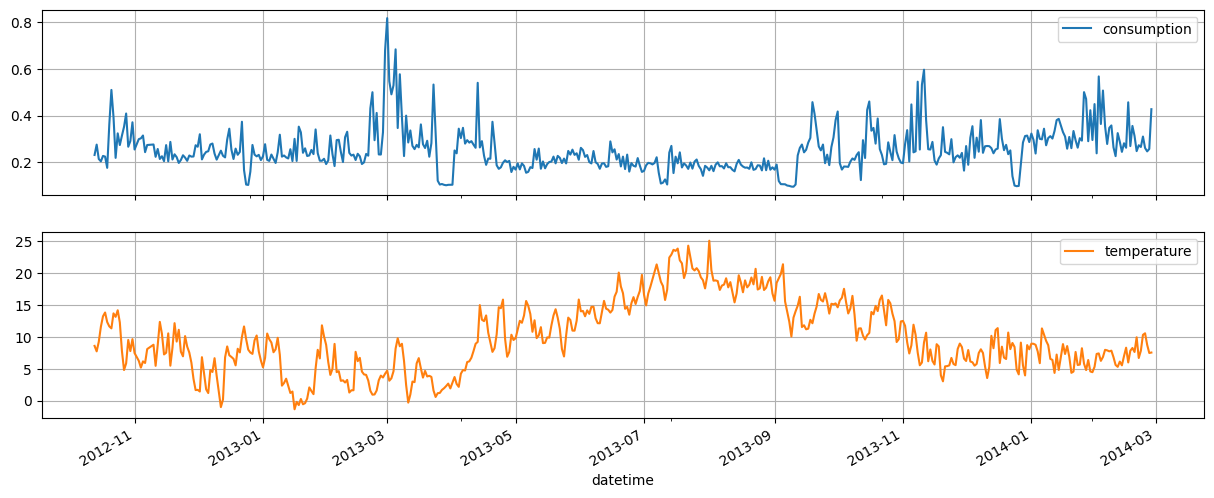

In [ ]:
daily_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

### Weekly

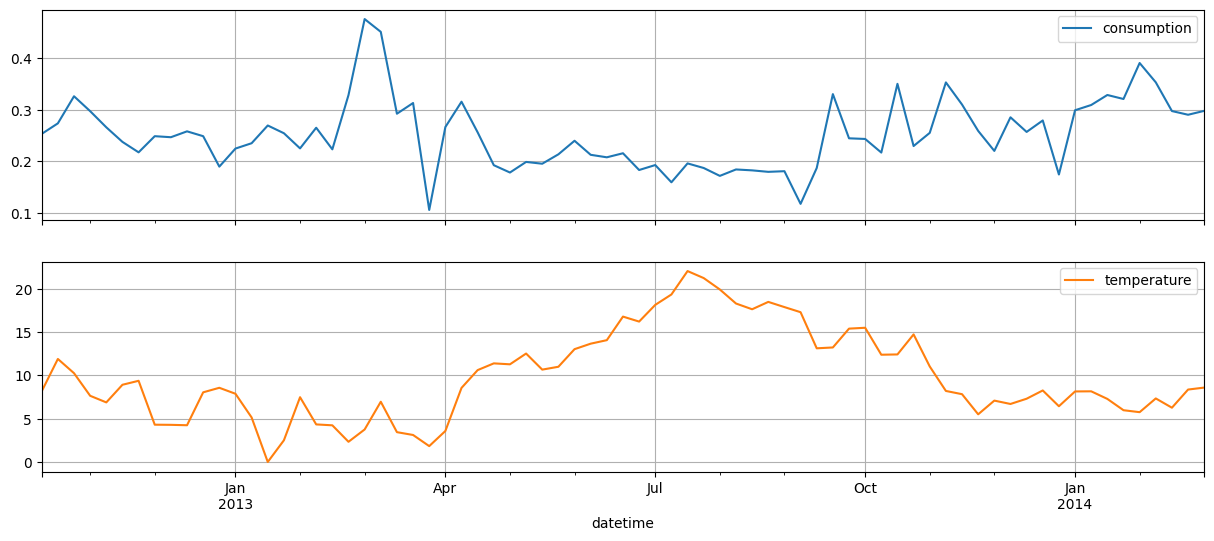

In [ ]:
weekly_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

### Monthly

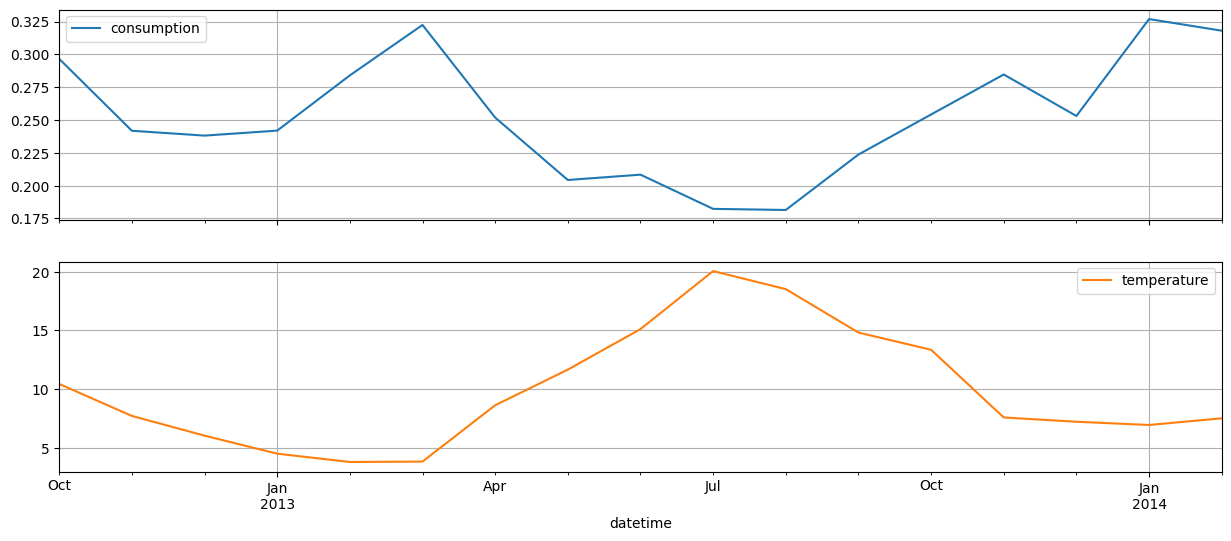

In [ ]:
monthly_data.plot(subplots=True, figsize=(15, 6), grid=True)
plt.show()

## Heatmap to show correlation

- shows a negative correlation

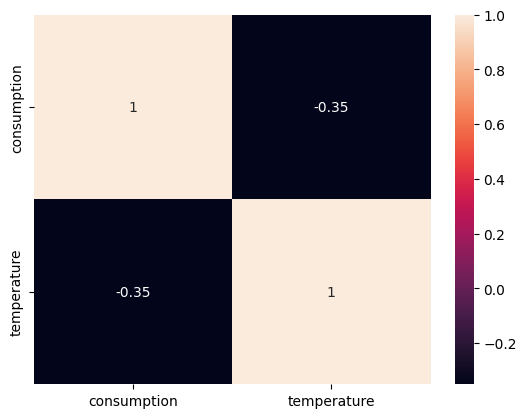

In [ ]:
corr = daily_data.corr()
sns.heatmap(corr, annot=True)
plt.show()

#Decomposition

## Daily Energy Consumption with Moving Average

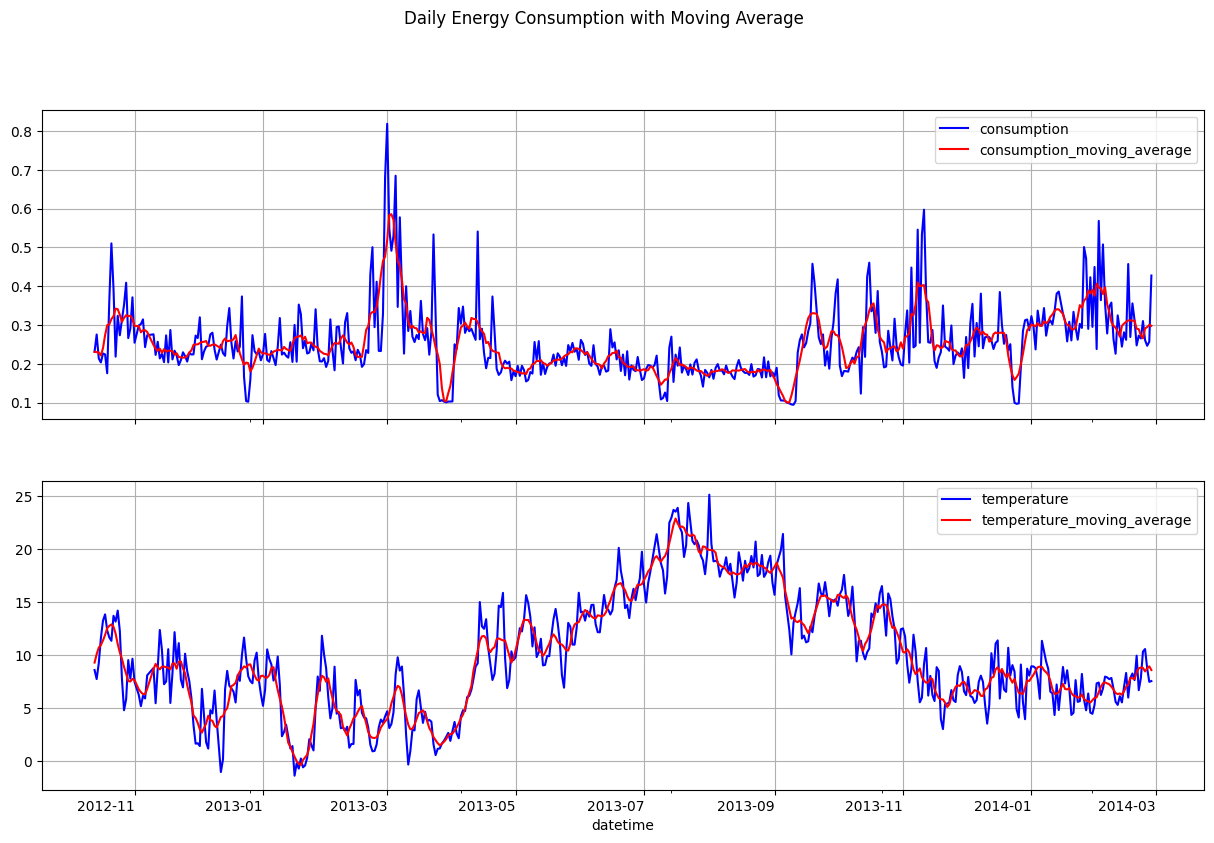

In [ ]:
rolling_window = '7D'
trend_ma = daily_data.rolling(window=rolling_window, center=True).mean().add_suffix('_moving_average')
ax = daily_data.plot(subplots=True, title='Daily Energy Consumption with Moving Average', color='blue', figsize=(15, 10), grid=True)
trend_ma.plot(subplots=True, ax=ax, color='red', grid=True)
plt.show()

## Seasonality

- the data is not stationary

### Hourly

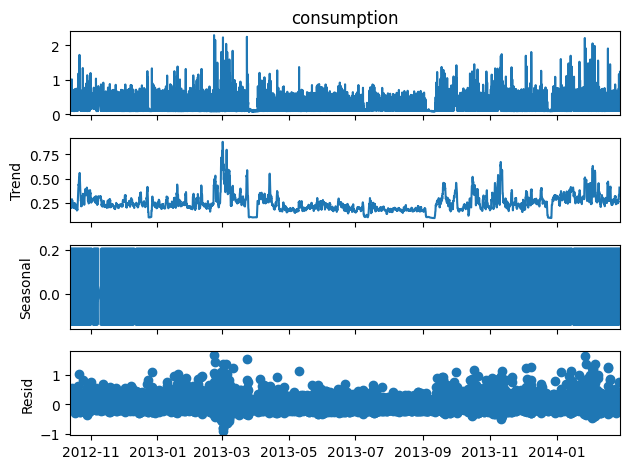

In [ ]:
result = seasonal_decompose(hourly_data['consumption'].dropna(), model='additive', period=24)
result.plot()
plt.show()

### Daily

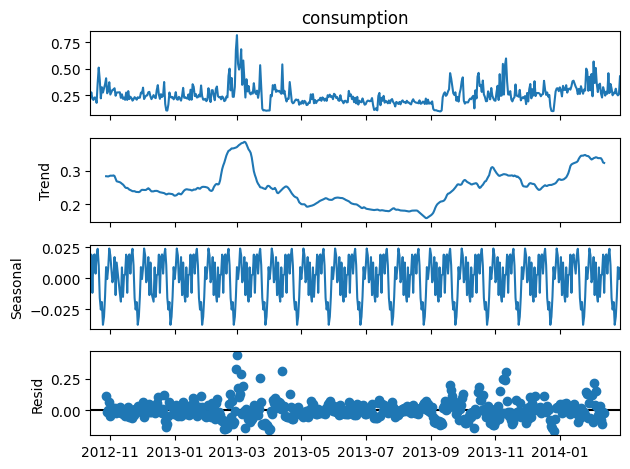

In [ ]:
result = seasonal_decompose(daily_data['consumption'].dropna(), model='additive', period=30)
result.plot()
plt.show()

## First Difference

### Hourly Data

In [ ]:
hourly_data_first_diff = hourly_data.diff()

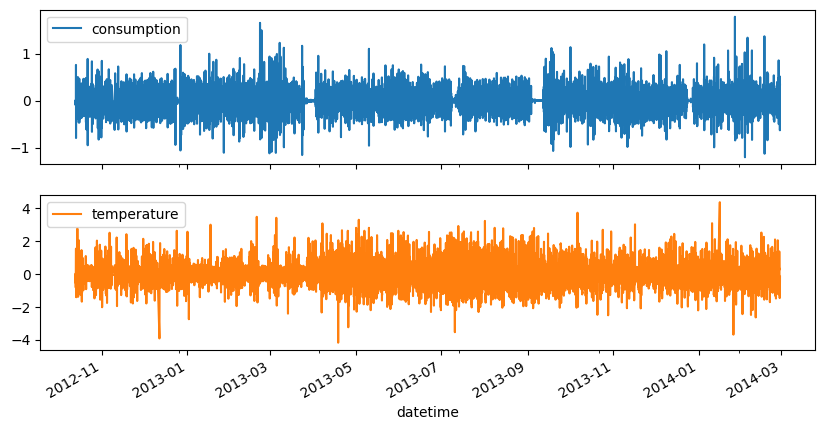

In [ ]:
hourly_data_first_diff.plot(figsize=(10, 5), subplots=True)
plt.show()

### Daily Data

In [ ]:
daily_data_first_diff = daily_data.diff().dropna()

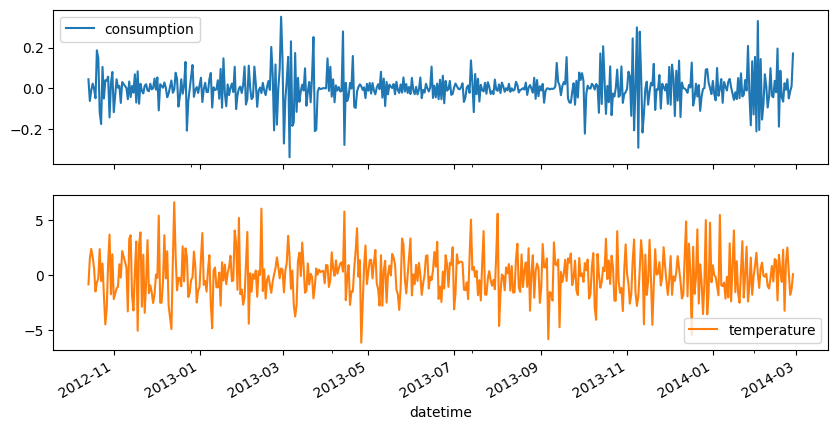

In [ ]:
daily_data_first_diff.plot(figsize=(10, 5), subplots=True)
plt.show()

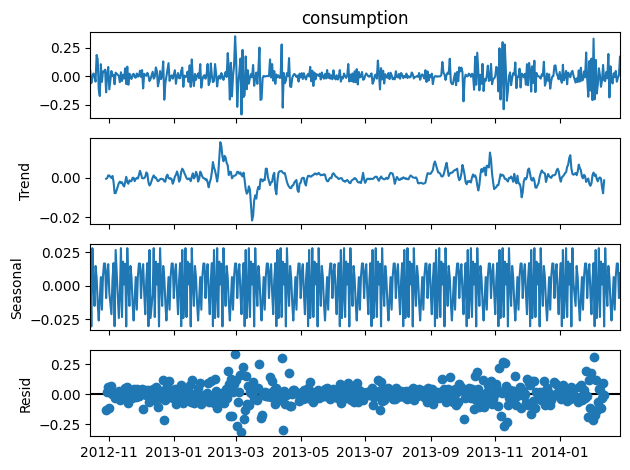

In [ ]:
result = seasonal_decompose(daily_data_first_diff['consumption'].dropna(), model='additive', period=30)
result.plot()
plt.show()

# Test stationarity for different time aggregations

In [ ]:
def test_stationarity(timeseries, title):

    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')

    rolling_mean = timeseries.rolling(window=10).mean()
    rolling_std = timeseries.rolling(window=10).std()

    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')

    plt.title(f'Rolling Statistics for {title} Data')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    adf_result = adfuller(timeseries.dropna())

    print('ADF Test Results:')
    print(f'ADF Statistic: {adf_result[0]:.6f}')
    print(f'p-value: {adf_result[1]:.6f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')

    if adf_result[1] <= 0.05:
        print("Conclusion: Time series is STATIONARY (ADF Test)")
    else:
        print("Conclusion: Time series is NON-STATIONARY (ADF Test)")

    kpss_result = kpss(timeseries.dropna())

    print('\nKPSS Test Results:')
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value:.4f}')

    if kpss_result[1] <= 0.05:
        print("Conclusion: Time series is NON-STATIONARY (KPSS Test)")
    else:
        print("Conclusion: Time series is STATIONARY (KPSS Test)")

    lags = min(40, len(timeseries) // 2 -1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(timeseries.dropna(), ax=axes[0], lags=lags, zero=False)
    plot_pacf(timeseries.dropna(), ax=axes[1], lags=lags, zero=False)
    plt.suptitle(f'ACF and PACF for {title} Data')
    plt.tight_layout()
    plt.show()

## For Hourly data

Looking at these charts, I can see this hourly data shows strong patterns. The data clearly has a daily cycle, with peaks appearing every 24 hours on the left chart. The first few hours have the strongest relationship, with each hour heavily influenced by what happened just before it.
The right chart (PACF) confirms this by showing that once you account for the immediate hour-to-hour relationship, most of the apparent patterns disappear, except for the daily cycle that pops up again around the 24-hour mark.
This is typical for hourly measurements where activities follow a daily rhythm

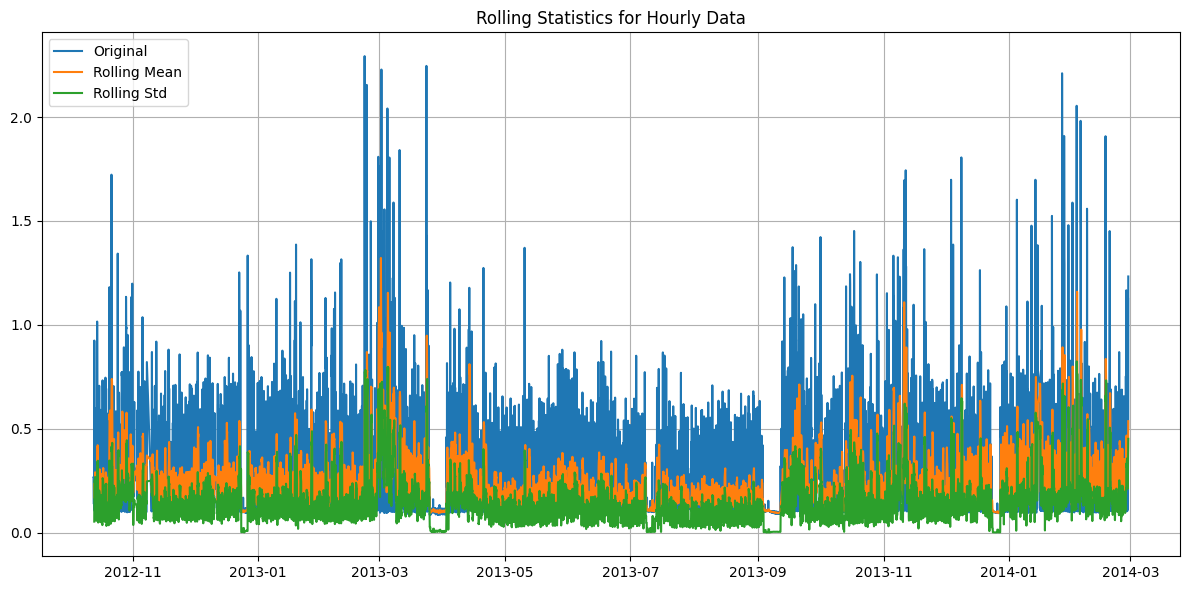

ADF Test Results:
ADF Statistic: -11.241630
p-value: 0.000000
Critical Values:
	1%: -3.4309
	5%: -2.8618
	10%: -2.5669
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 1.4260
p-value: 0.0100
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is NON-STATIONARY (KPSS Test)


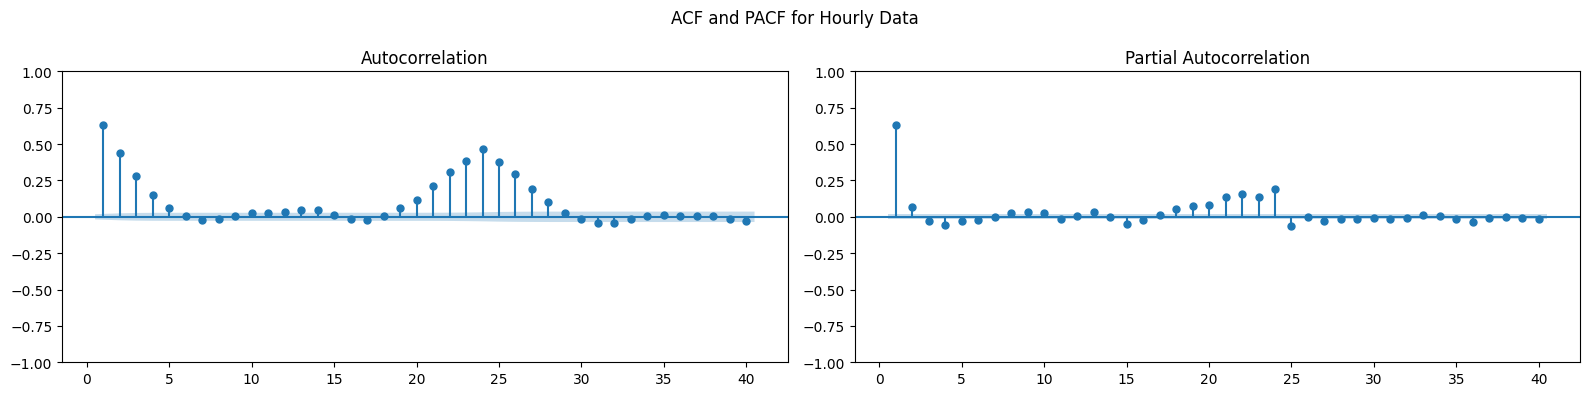

In [ ]:
test_stationarity(hourly_data['consumption'], "Hourly")

#ARIMA

## Box-jenkins

### Identification

#### is the time series stationary

##### Daily data

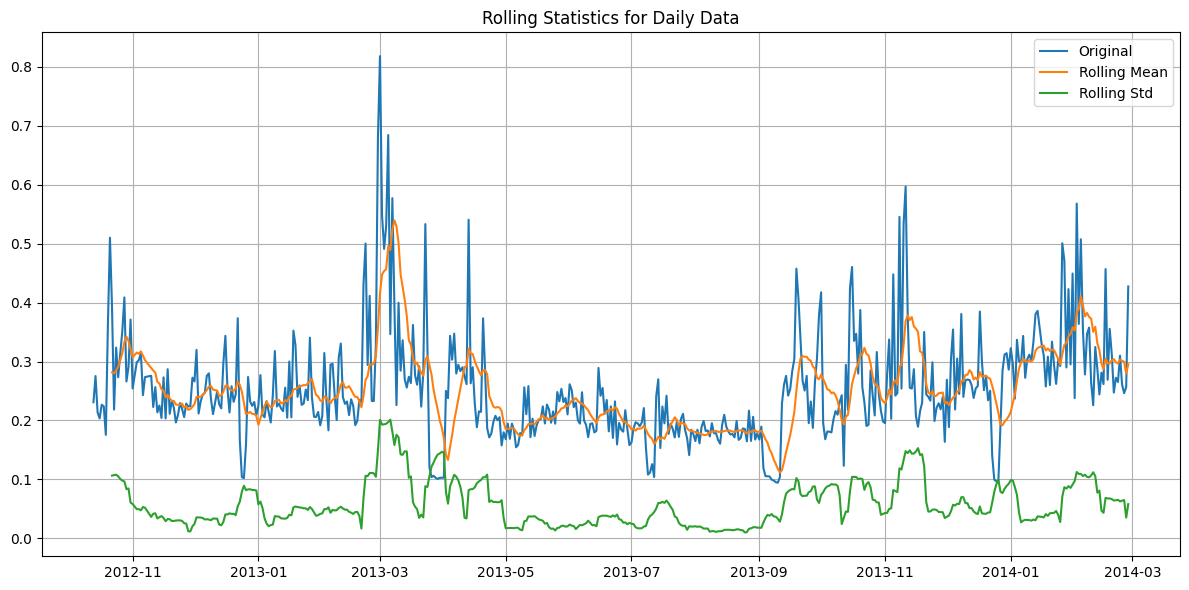

ADF Test Results:
ADF Statistic: -4.923303
p-value: 0.000031
Critical Values:
	1%: -3.4438
	5%: -2.8675
	10%: -2.5699
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 0.3574
p-value: 0.0955
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is STATIONARY (KPSS Test)


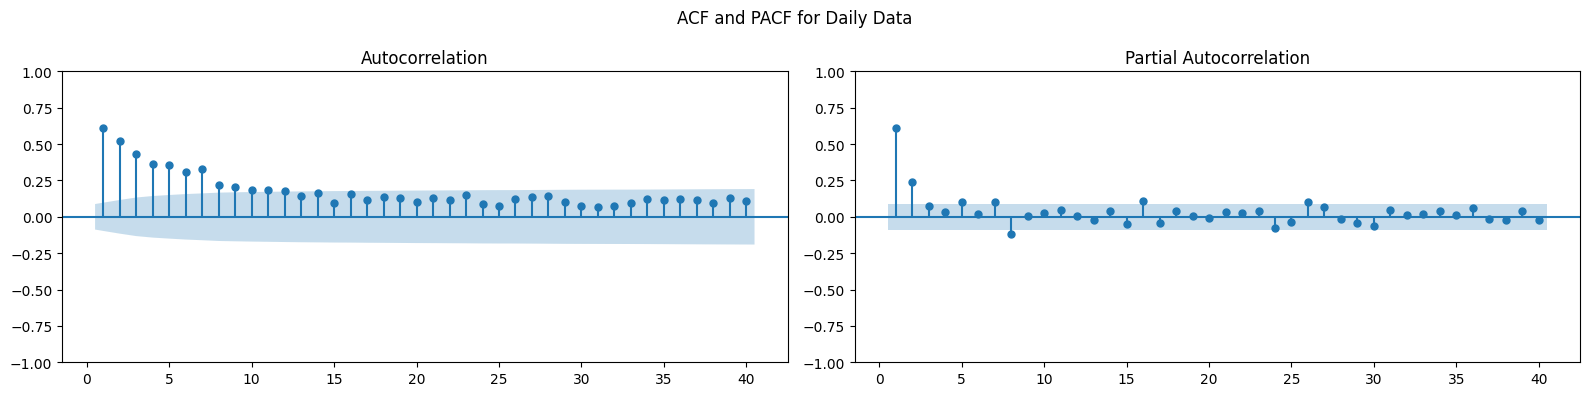

In [ ]:
test_stationarity(daily_data['consumption'], "Daily")

### Modeling

In [ ]:
arima_model = ARIMA(daily_data['consumption'], order=(3, 0, 0))
result = arima_model.fit()

In [ ]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:            consumption   No. Observations:                  498
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 609.999
Date:                Sat, 26 Apr 2025   AIC                          -1209.997
Time:                        21:06:24   BIC                          -1188.944
Sample:                             0   HQIC                         -1201.735
                                - 498                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2528      0.016     16.040      0.000       0.222       0.284
ar.L1          0.4473      0.026     17.233      0.000       0.396       0.498
ar.L2          0.2042      0.032      6.408      0.0

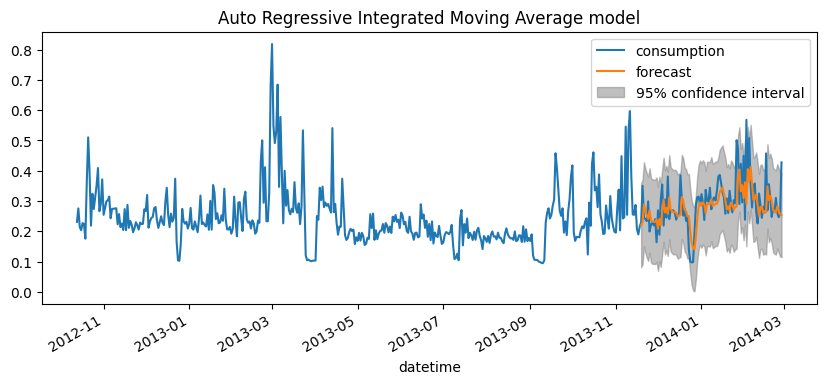

In [ ]:
ax = daily_data['consumption'].plot(figsize=(10, 4))
plot_predict(result, start=daily_data.index[-100], end=daily_data.index[-1], ax=ax, alpha=0.05)
plt.title('Auto Regressive Integrated Moving Average model')
plt.show()

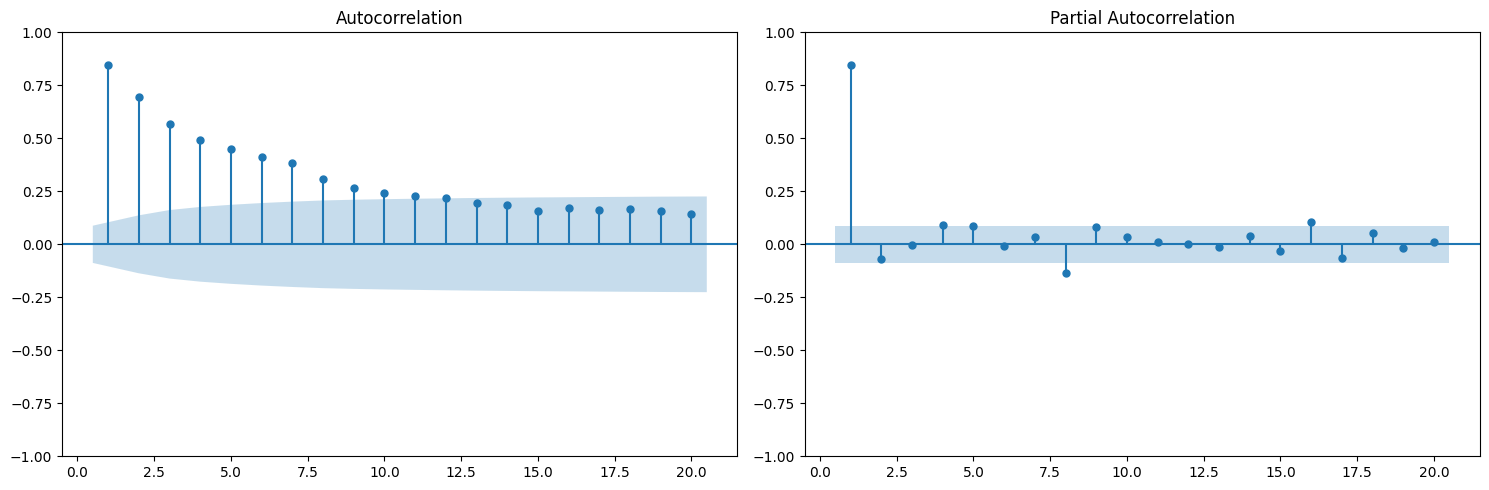

In [ ]:
forecast = result.get_prediction(start=daily_data.index[0], end=daily_data.index[-1])
forecast_mean = forecast.predicted_mean
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(forecast_mean, ax=ax[0], lags=20, zero=False)
plot_pacf(forecast_mean, ax=ax[1], lags=20, zero=False)
plt.tight_layout()
plt.show()

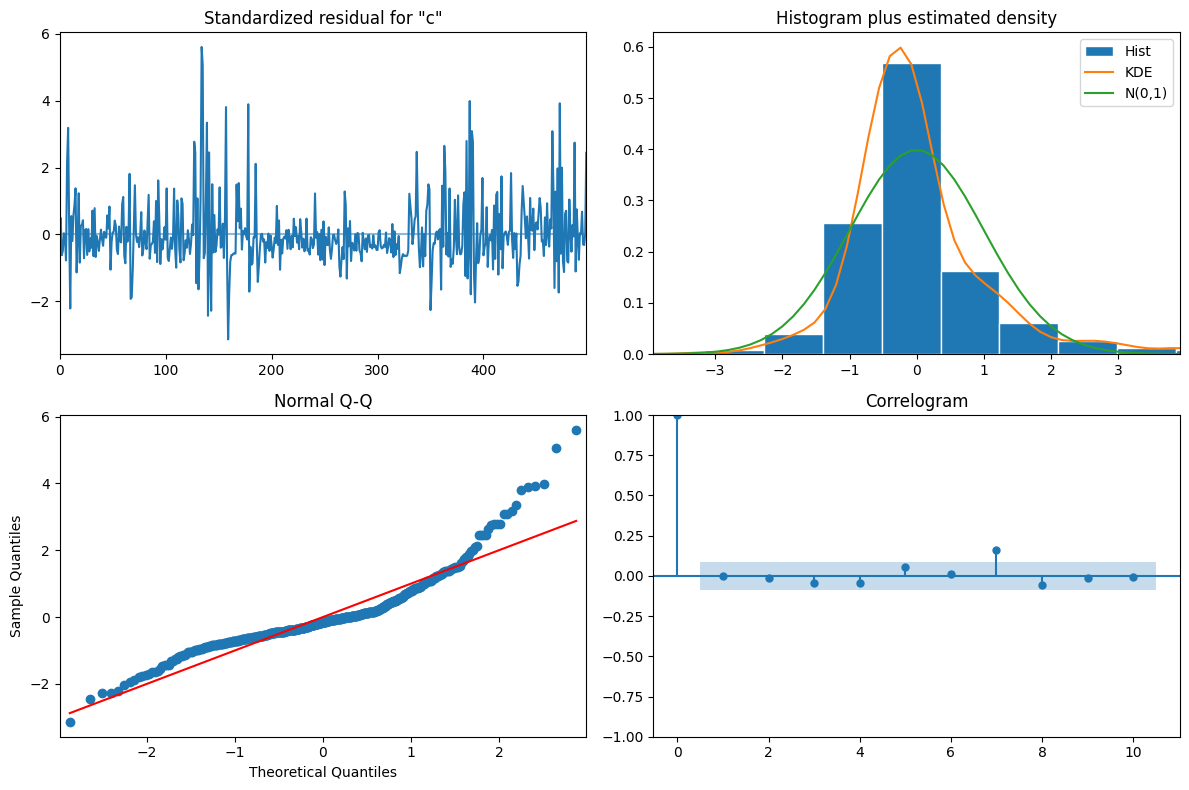

In [ ]:
result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

- obvious structure in residual
- the KDE and The normal distristribution dont fit
- Q-Q plot the points dont fit red line
- the correlogram id good

#ARIMAX

## Box-jenkins

### Identification

#### is the time series stationary

##### Daily data

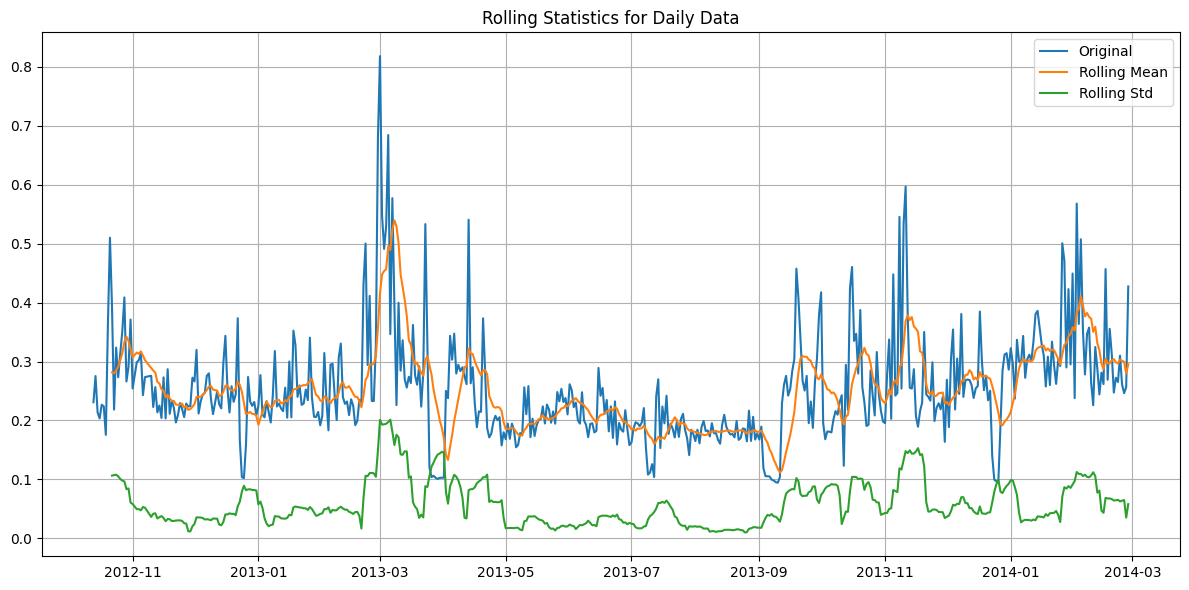

ADF Test Results:
ADF Statistic: -4.923303
p-value: 0.000031
Critical Values:
	1%: -3.4438
	5%: -2.8675
	10%: -2.5699
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 0.3574
p-value: 0.0955
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is STATIONARY (KPSS Test)


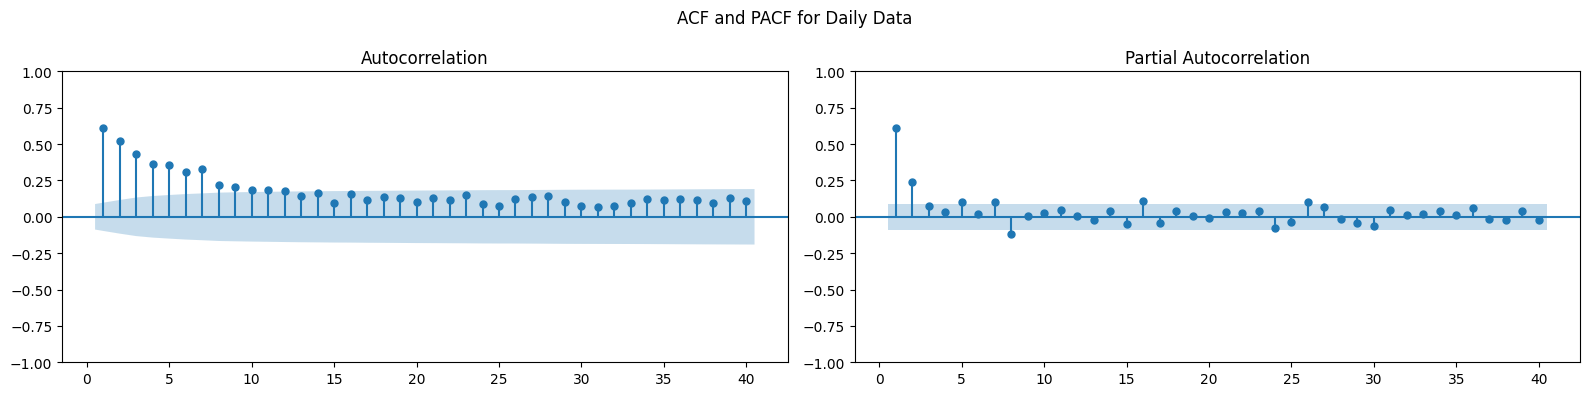

In [ ]:
test_stationarity(daily_data['consumption'], "Daily")

### Modeling

In [ ]:
arima_model = SARIMAX(daily_data['consumption'], order=(3, 0, 1), exog=daily_data['temperature'])
result = arima_model.fit()

In [ ]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:            consumption   No. Observations:                  498
Model:               SARIMAX(3, 0, 1)   Log Likelihood                 607.791
Date:                Sat, 26 Apr 2025   AIC                          -1203.582
Time:                        21:16:53   BIC                          -1178.318
Sample:                             0   HQIC                         -1193.667
                                - 498                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -0.0027      0.002     -1.596      0.110      -0.006       0.001
ar.L1           1.3942      0.045     31.270      0.000       1.307       1.482
ar.L2          -0.2304      0.048     -4.777    

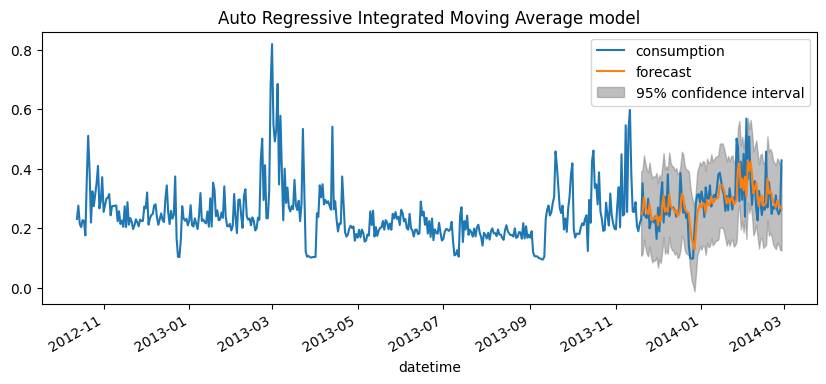

In [ ]:
ax = daily_data['consumption'].plot(figsize=(10, 4))
plot_predict(result, start=daily_data.index[-100], end=daily_data.index[-1], ax=ax, alpha=0.05)
plt.title('Auto Regressive Integrated Moving Average model')
plt.show()

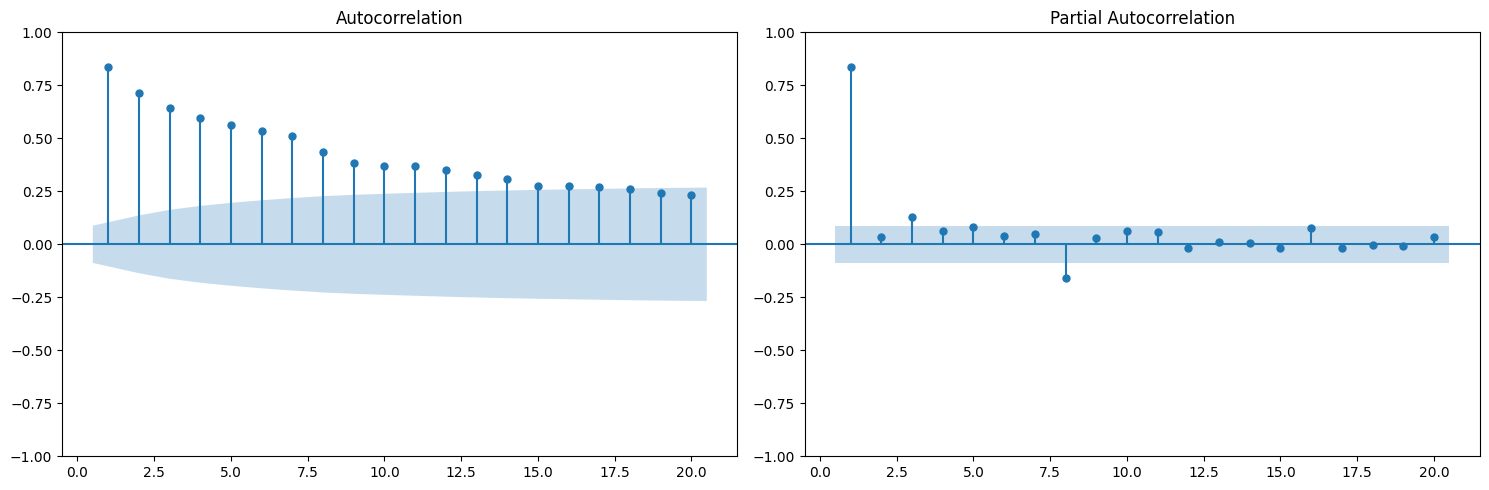

In [ ]:
forecast = result.get_prediction(start=daily_data.index[0], end=daily_data.index[-1])
forecast_mean = forecast.predicted_mean
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(forecast_mean, ax=ax[0], lags=20, zero=False)
plot_pacf(forecast_mean, ax=ax[1], lags=20, zero=False)
plt.tight_layout()
plt.show()

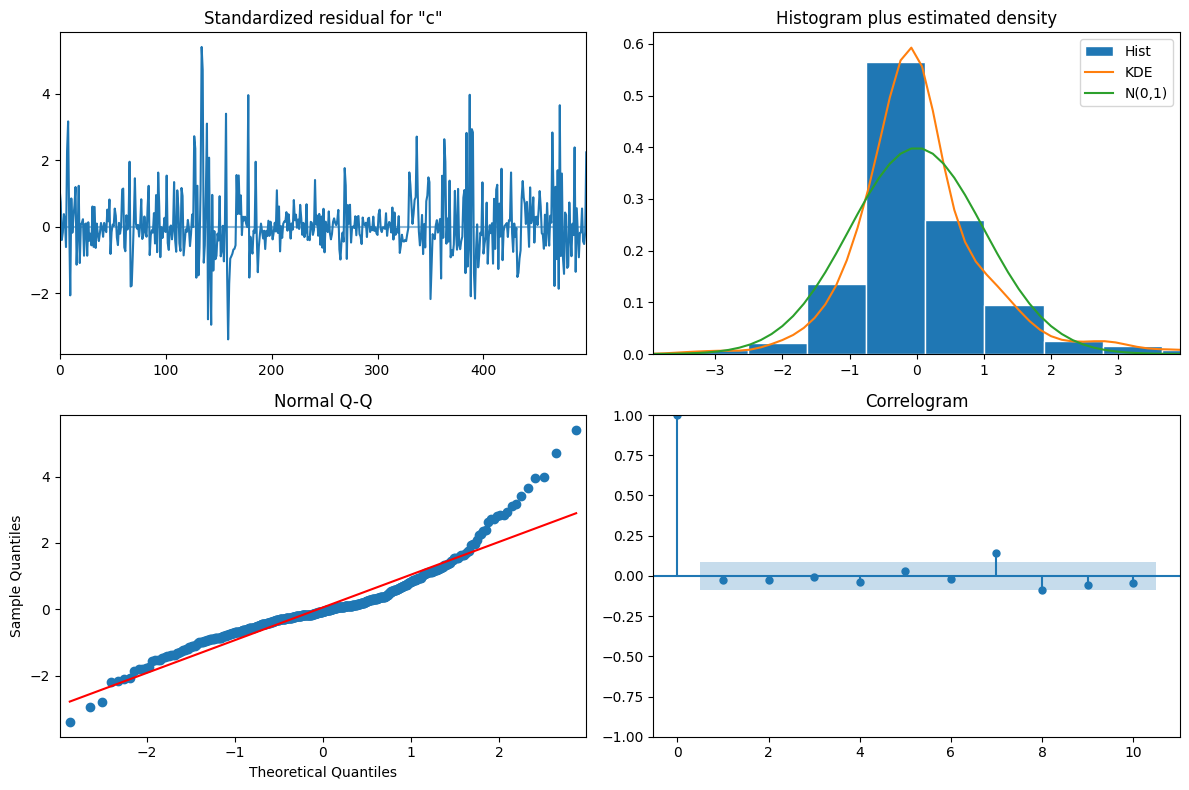

In [ ]:
result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

- obvious structure in residual
- the KDE and The normal distristribution dont fit
- Q-Q plot the points dont fit red line
- the correlogram id good

- **ARIMAX is better than ARIMA**

#SARIMA

## Box-jenkins

### Identification

#### is the time series stationary

##### Daily data

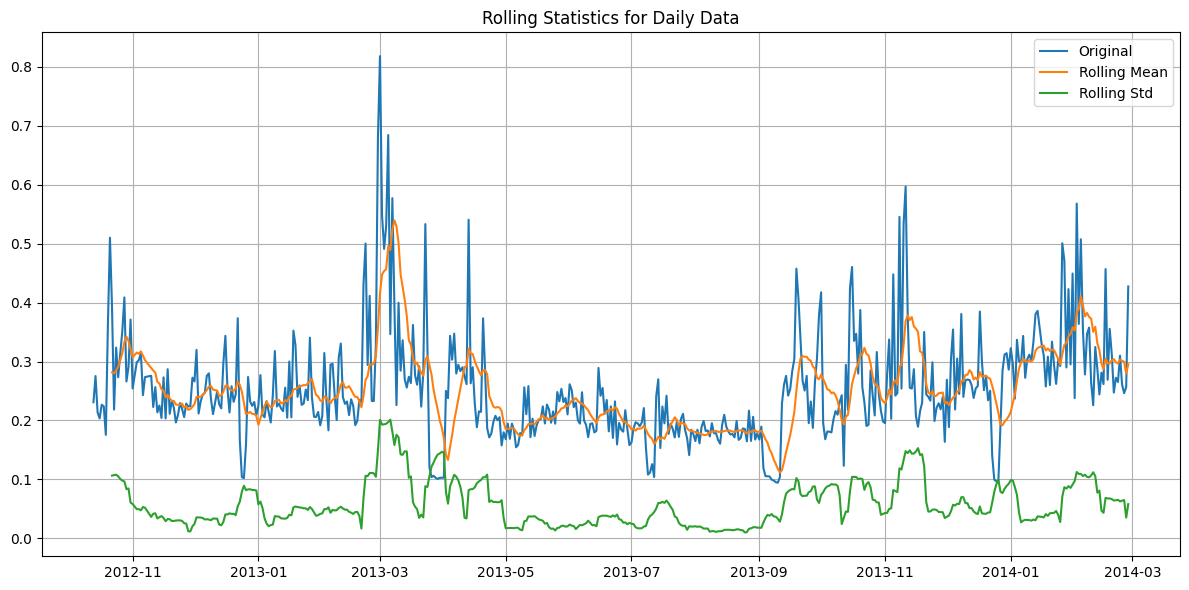

ADF Test Results:
ADF Statistic: -4.923303
p-value: 0.000031
Critical Values:
	1%: -3.4438
	5%: -2.8675
	10%: -2.5699
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 0.3574
p-value: 0.0955
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is STATIONARY (KPSS Test)


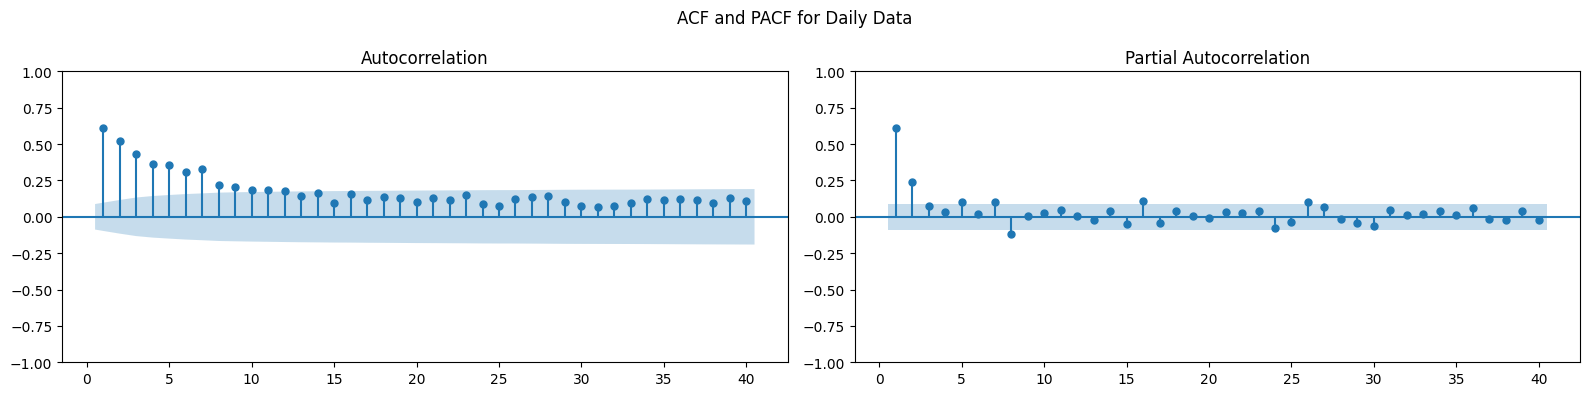

In [ ]:
test_stationarity(daily_data['consumption'], "Daily")

### Modeling

In [ ]:
arima_model = SARIMAX(daily_data['consumption'], order=(3, 0, 0), seasonl_order=(3, 1, 1, 6))
result = arima_model.fit()

In [ ]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:            consumption   No. Observations:                  498
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 588.485
Date:                Sat, 26 Apr 2025   AIC                          -1168.971
Time:                        21:25:04   BIC                          -1152.128
Sample:                             0   HQIC                         -1162.360
                                - 498                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5394      0.026     20.864      0.000       0.489       0.590
ar.L2          0.2745      0.031      8.859      0.000       0.214       0.335
ar.L3          0.1635      0.033      5.025      0.0

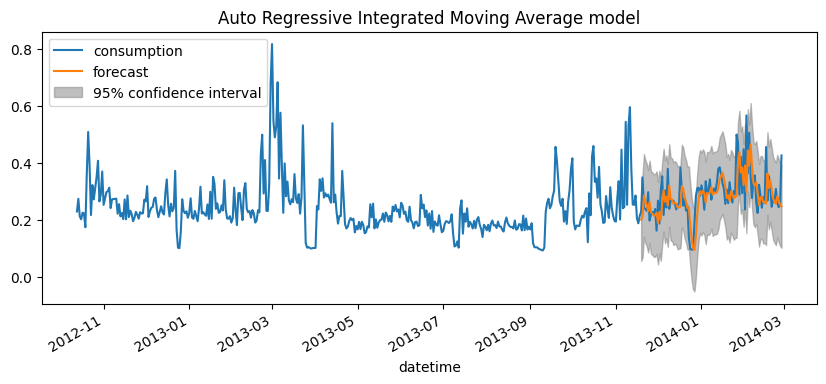

In [ ]:
ax = daily_data['consumption'].plot(figsize=(10, 4))
plot_predict(result, start=daily_data.index[-100], end=daily_data.index[-1], ax=ax, alpha=0.05)
plt.title('Auto Regressive Integrated Moving Average model')
plt.show()

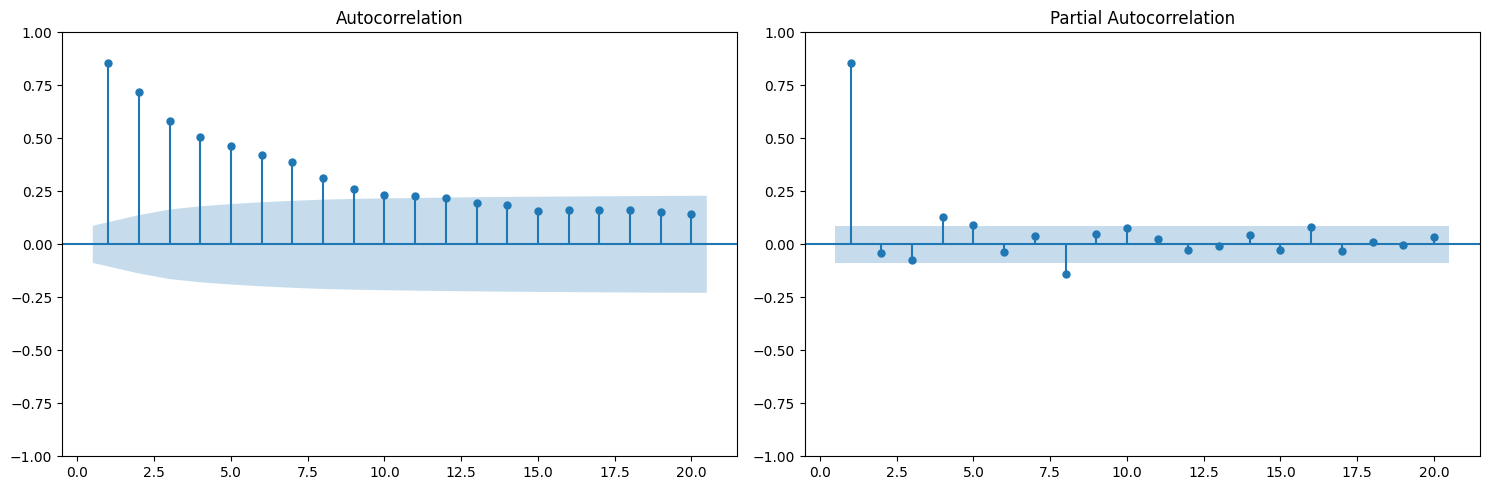

In [ ]:
forecast = result.get_prediction(start=daily_data.index[0], end=daily_data.index[-1])
forecast_mean = forecast.predicted_mean
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(forecast_mean, ax=ax[0], lags=20, zero=False)
plot_pacf(forecast_mean, ax=ax[1], lags=20, zero=False)
plt.tight_layout()
plt.show()

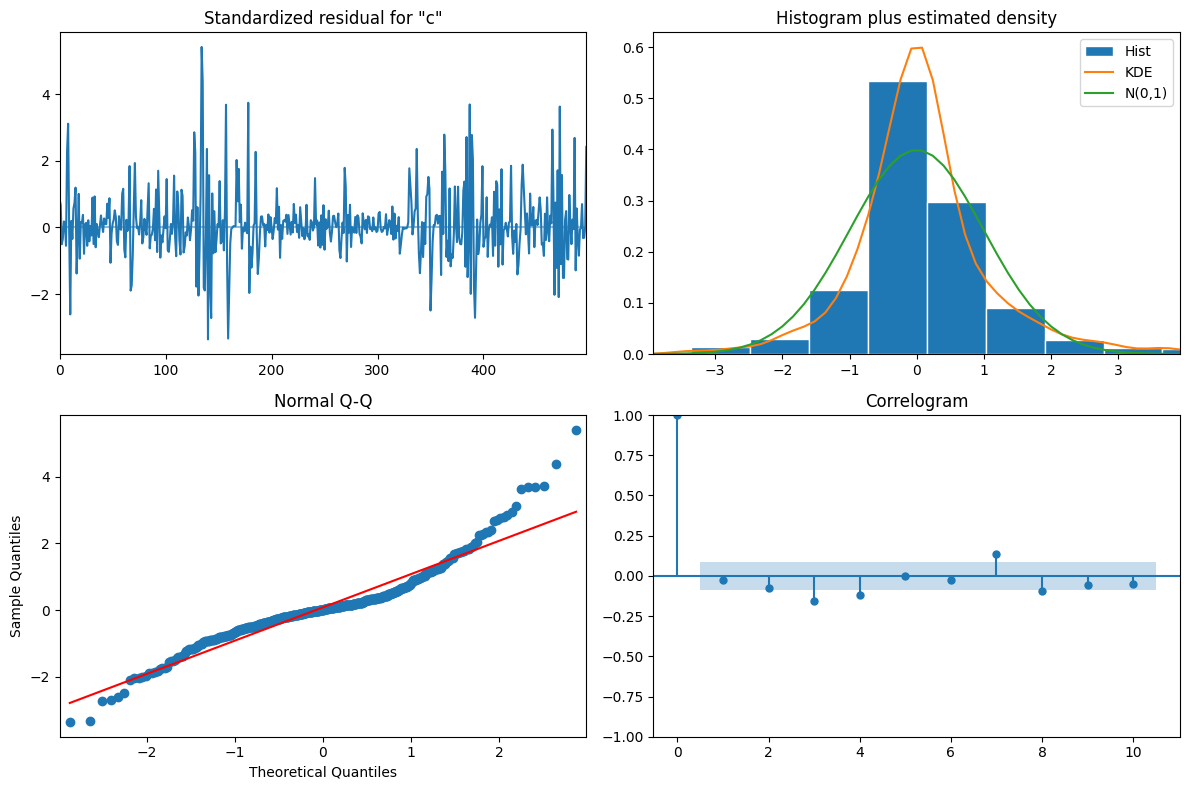

In [ ]:
result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

- obvious structure in residual
- the KDE and The normal distristribution dont fit
- Q-Q plot the points dont fit red line
- the correlogram id good

- **SARIMA looks the same as ARIMAX**

#SARIMAX

## Box-jenkins

### Identification

#### is the time series stationary

##### Daily data

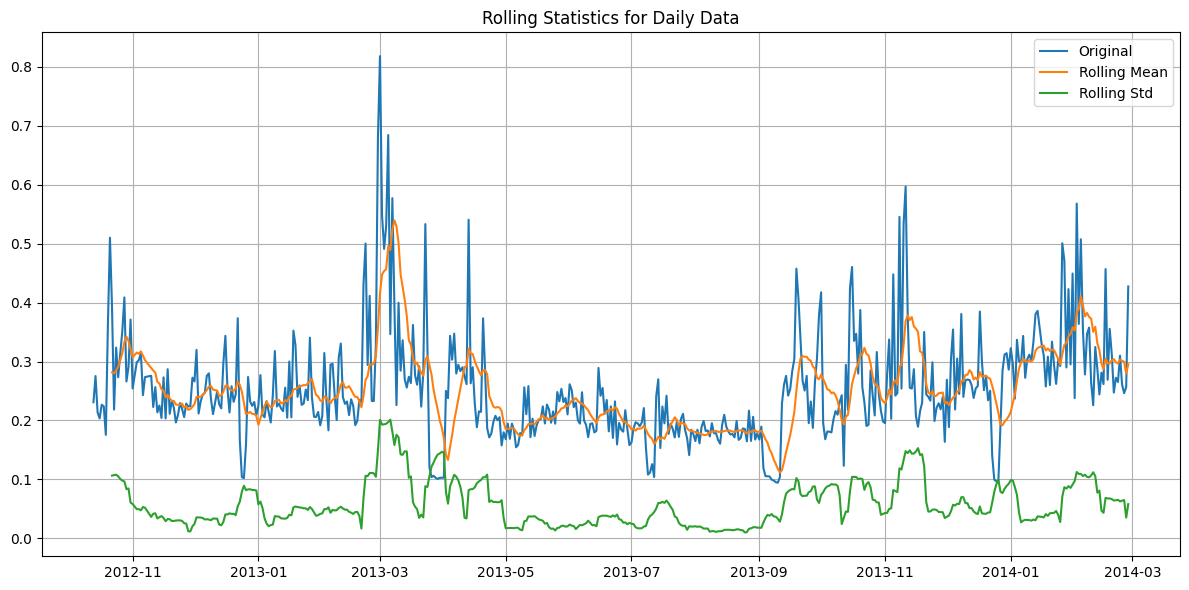

ADF Test Results:
ADF Statistic: -4.923303
p-value: 0.000031
Critical Values:
	1%: -3.4438
	5%: -2.8675
	10%: -2.5699
Conclusion: Time series is STATIONARY (ADF Test)

KPSS Test Results:
KPSS Statistic: 0.3574
p-value: 0.0955
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Conclusion: Time series is STATIONARY (KPSS Test)


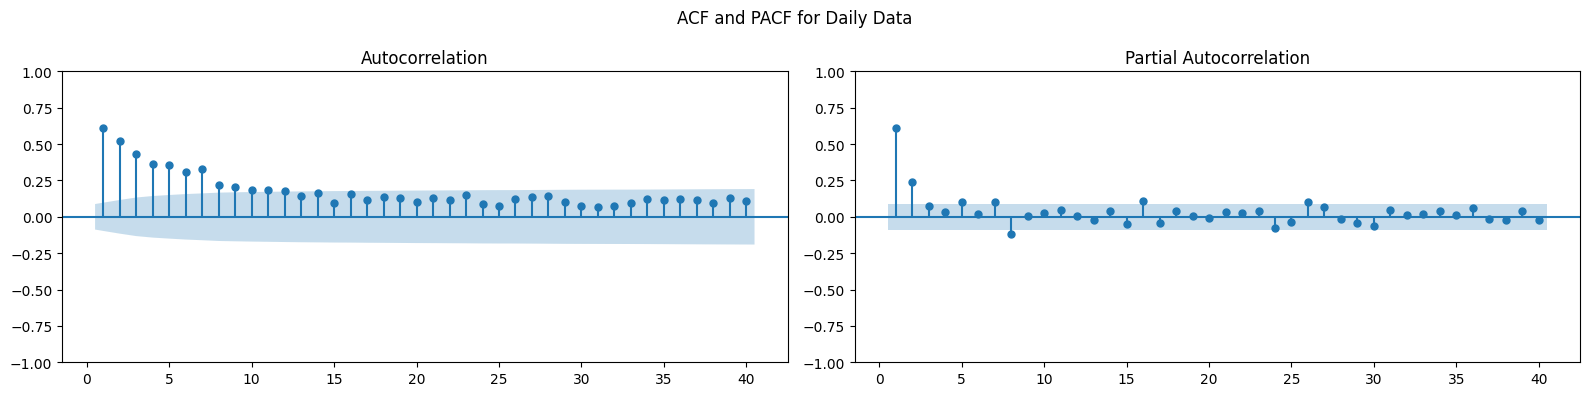

In [ ]:
test_stationarity(daily_data['consumption'], "Daily")

### Modeling

In [ ]:
arima_model = SARIMAX(daily_data['consumption'], order=(3, 0, 0), seasonl_order=(3, 1, 1, 6), exog=daily_data['temperature'])
result = arima_model.fit()

In [ ]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:            consumption   No. Observations:                  498
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 590.492
Date:                Sat, 26 Apr 2025   AIC                          -1170.984
Time:                        21:28:07   BIC                          -1149.931
Sample:                             0   HQIC                         -1162.721
                                - 498                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature    -0.0033      0.002     -1.922      0.055      -0.007     6.5e-05
ar.L1           0.5451      0.026     20.755      0.000       0.494       0.597
ar.L2           0.2723      0.031      8.755    

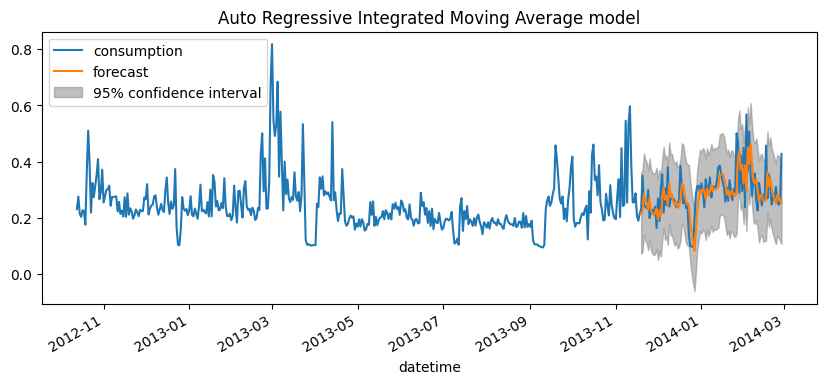

In [ ]:
ax = daily_data['consumption'].plot(figsize=(10, 4))
plot_predict(result, start=daily_data.index[-100], end=daily_data.index[-1], ax=ax, alpha=0.05)
plt.title('Auto Regressive Integrated Moving Average model')
plt.show()

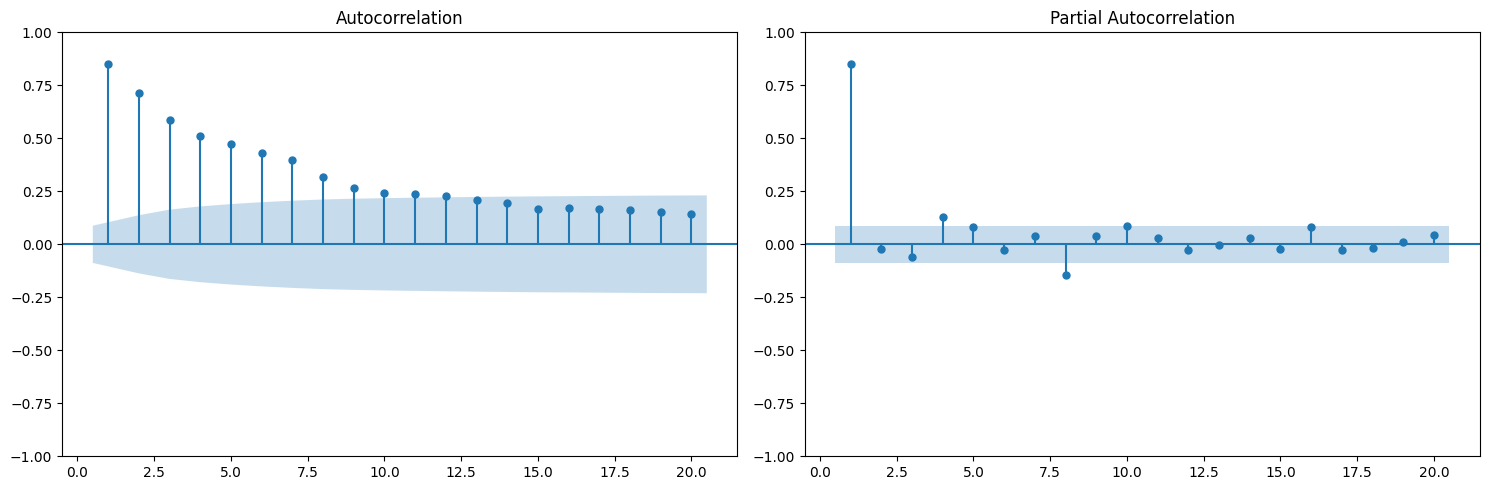

In [ ]:
forecast = result.get_prediction(start=daily_data.index[0], end=daily_data.index[-1])
forecast_mean = forecast.predicted_mean
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(forecast_mean, ax=ax[0], lags=20, zero=False)
plot_pacf(forecast_mean, ax=ax[1], lags=20, zero=False)
plt.tight_layout()
plt.show()

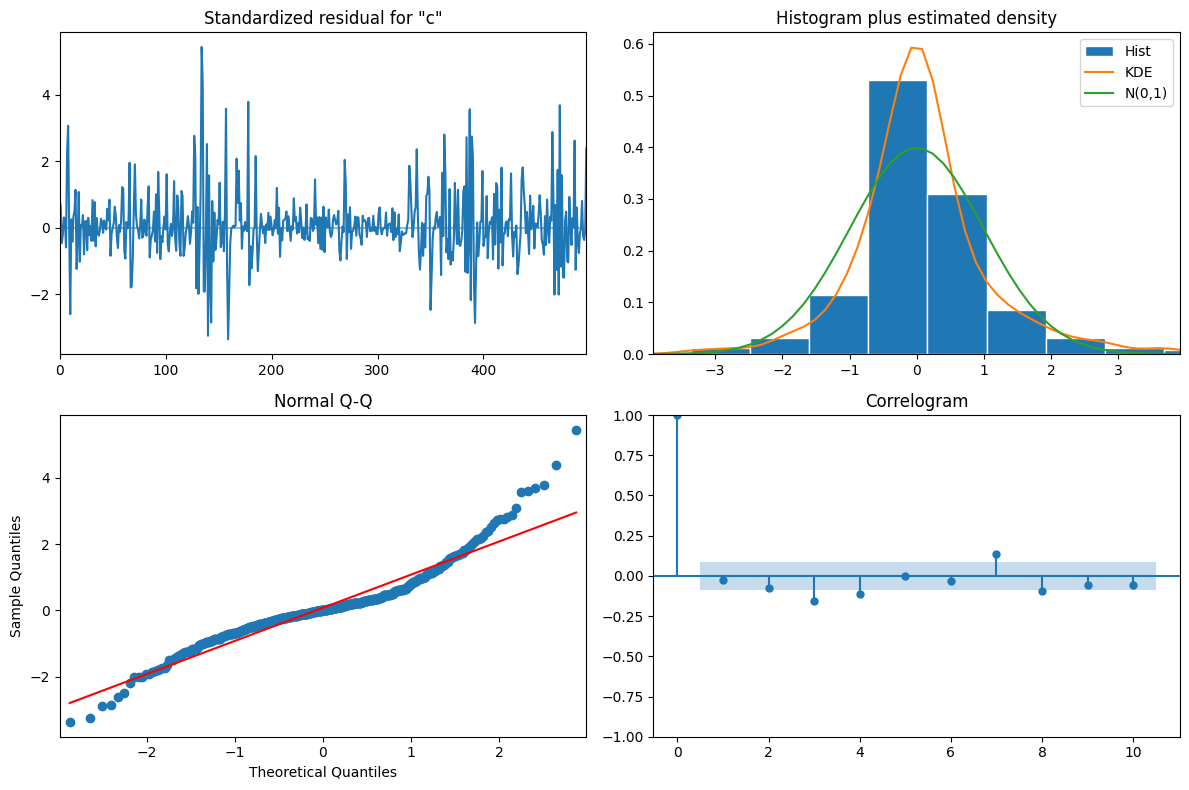

In [ ]:
result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

- obvious structure in residual
- the KDE and The normal distristribution dont fit
- Q-Q plot the points dont fit red line
- the correlogram id good

- **SARIMAX looks the same as SARIMA**

#AutoARIMA

In [ ]:
model = auto_arima(daily_data['consumption'], seasonal=True, stepwise=True, suppress_warnings=True)

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  498
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 608.885
Date:                Sat, 26 Apr 2025   AIC                          -1209.769
Time:                        21:30:54   BIC                          -1192.935
Sample:                             0   HQIC                         -1203.162
                                - 498                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7934      0.054     14.690      0.000       0.688       0.899
ma.L1         -1.3489      0.064    -21.002      0.000      -1.475      -1.223
ma.L2          0.3651      0.056      6.497      0.0

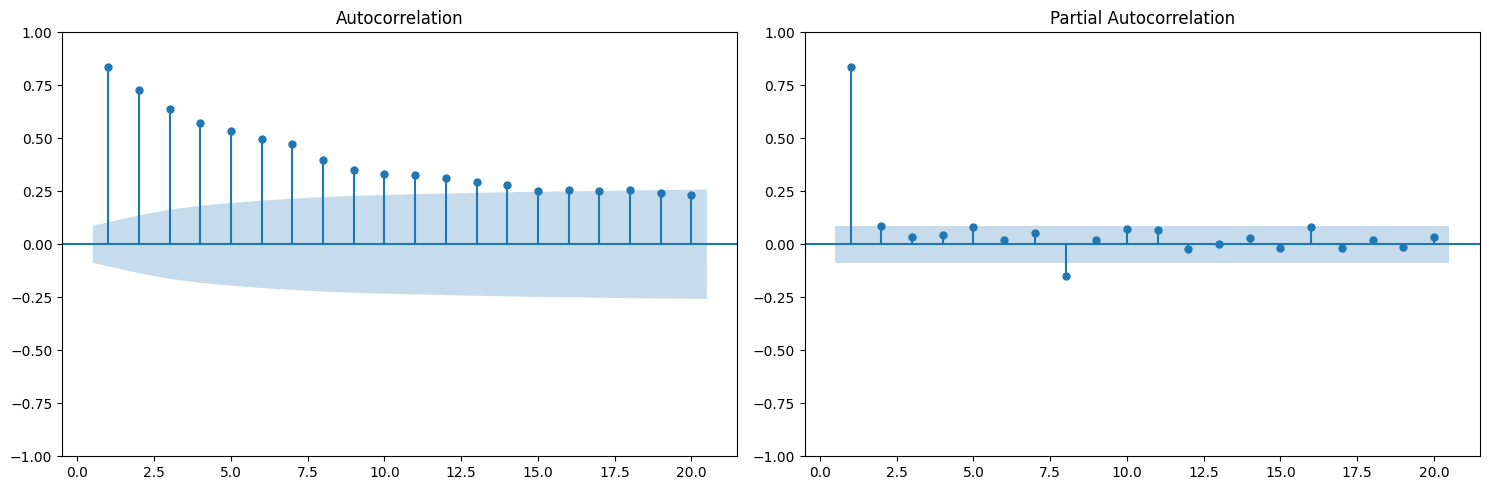

In [ ]:
forecast = result.get_prediction(start=daily_data.index[0], end=daily_data.index[-1])
forecast_mean = forecast.predicted_mean
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(forecast_mean, ax=ax[0], lags=20, zero=False)
plot_pacf(forecast_mean, ax=ax[1], lags=20, zero=False)
plt.tight_layout()
plt.show()

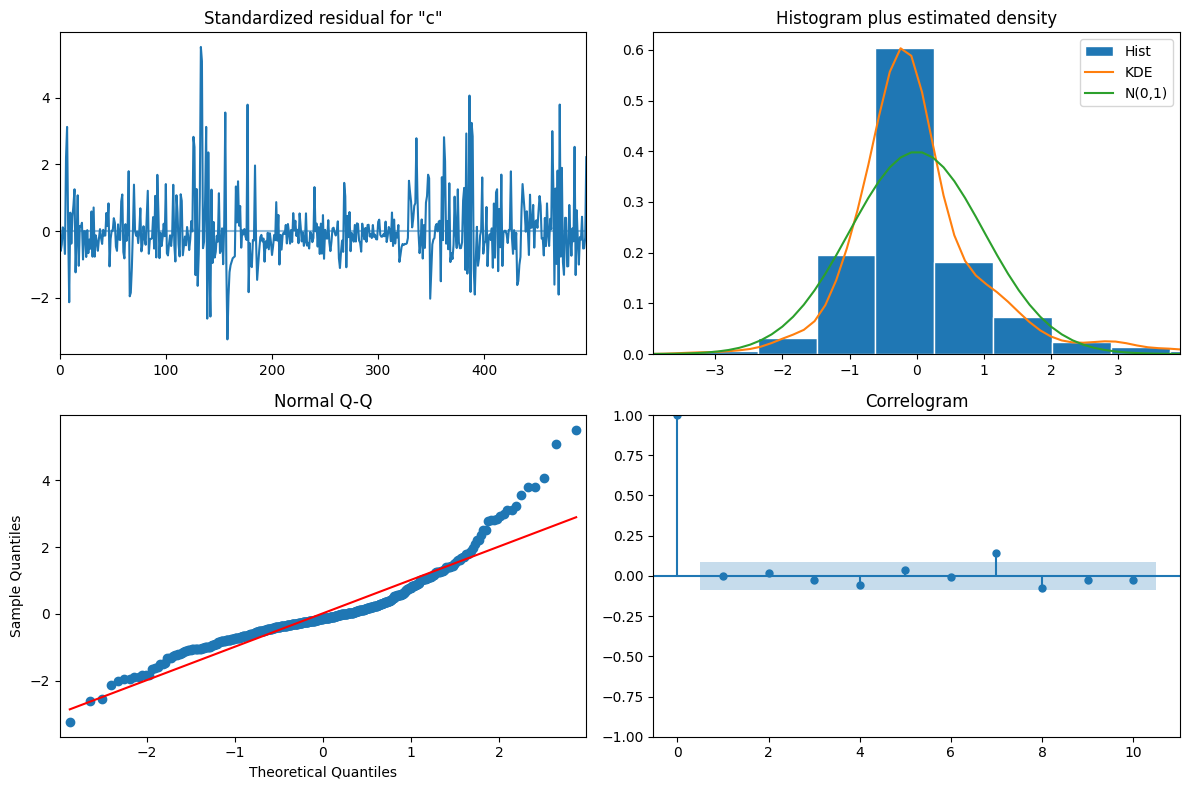

In [ ]:
result.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()